## `lab09`—Music of the Spheres

❖ Objectives

-   Utilize NumPy to construct and solve a numerical system.
-   Apply the finite difference method to solve the wave equation in one dimensions.
-   Utilize SciPy for special functions useful in solving the wave equation in two dimensions.

<div class="alert alert-warning">
**Pair Programming**
<br />
Since this lab is fairly involved, we encourage you to work in pairs *at a single machine*.  You and your partner will consult, and should occasionally trade off so that the time at the keyboard is roughly equal.  At the end, when you report collaborators, please report the names and NetIDs of all partners in this lab exercise.  (In exceptional cases, such as the room layout, trios are permitted.)
</div>

The ancient Greek Pythagoras believed that numbers—particularly *ratios*—were divine correspondences which underlay and revealed the nature of the cosmos.  According to legend, he discovered the ratios of musical notes by listening to ringing hammers of various weights as well as strings of different lengths, and launched the theoretical exploration of both music and pure mathematics.

In today's lab, we will explore harmonics and numerically solve certain cases of string and plate harmonics using NumPy and SciPy.  As we will use these throughout, first we'll go ahead and import the libraries:

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Simple String Harmonics

A plucked string vibrates.  This is a simple observation, but how much of music depends on it!  We're going to model how vibrations travel as waves through a string, just like these vibrations:

![](https://upload.wikimedia.org/wikipedia/commons/0/00/Vibration_corde_trois_modes.gif)

Vibrations are waves, and as such they are governed by the *wave equation*.  We'll numerically solve this equation for a string and then for a plate, which will give you an idea how basic numerical algorithms work in Python.

#### Governing Equations

Although you don't need to know differential equations to complete this lab, a little background will help you comprehend why the solutions work as they do.  For a string in one dimension, we can write the *wave equation* to describe how it moves in space given certain *boundary conditions*  The boundary conditions specify that the string ends are secured, or *fixed*.  For a $1 \,\text{m} \times 1 \,\text{m}$ plate,

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray}
$$

$u$ describes the position of the string at location $x$ at time $t$.  The wave equation means that the propagation of a disturbance (a wave) in *time* can be related to its propagation in space via the speed of travel $c$.  That's just what the second derivatives do in this equation.

We'll use the *finite difference method* to numerically solve this problem.  In FDM, one converts a differential equation over a continuous space to a matrix equation over a grid.

![](./img/fdm.png)

(As you can see, one consequence of this is that we will only have solutions at grid points rather than everywhere.  Some error is necessarily introduced in this process.)

We will approximate a spatial derivative thus:

$$
\frac{\partial u}{\partial x} \approx \frac{u_{i}-w_{i-1}}{\Delta x}
$$

($i$ means the grid point number).  We will do the same in time:

$$
\frac{\partial u}{\partial t} \approx \frac{u^{n}-u^{n-1}}{\Delta t}
$$

($n$ means the time step number, *not* an exponent).

So instead of trying to analytically solve the equation

$$
\frac{\partial^2 u}{\partial t^2} + c^2 \frac{\partial^2 u}{\partial x^2} = 0
\hspace{5cm}
\begin{eqnarray}
u(0, t) = 0 \\
u(1, t) = 0
\end{eqnarray} \,\text{,}
$$

we'll numerically solve the equation

$$
\frac{u^{n+1}_{i} - 2u^{n}_{i} + u^{n-1}_{i}}{\Delta t^2} - c^2 \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}}{\Delta x^2} = 0
\hspace{2cm}
\begin{eqnarray}
u^n_0 = 0 \\
u^n_{i_{\max}} = 0
\end{eqnarray} \,\text{.}
$$

or, for a single grid point,

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

$\Delta t$ and $\Delta x$ represent the time step size and spatial grid size, respectively.

That looks intimidating, doesn't it?  Let's see what's going on.

Basically, we've created a grid describing a string.  We then have a way of relating the *current* ($n$) and *past* ($n-1$) grids together to predict the *next step* grid ($n+1$).  This equation just tells us what the proportions of the other grid values should be in order to obtain $u^{n+1}_{i}$.

![](./img/fdm-stencil.png)

#### Implementation

First let's define the broad parameters of our simulation.  Any time we want to run this simulation for slightly different circumstances, these are the values we need to revisit.

-   Create the following variables:

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `c`      | `2.0`  | wave velocity |
| `t`      | `10.0` | maximum time |
| `nt`     | `100`  | number of time steps (total) |
| `xmin`   | `0.0`  | minimum $x$-coordinate |
| `xmax`   | `1.0`  | maximum $x$-coordinate |
| `nx`     | `25`   | number of grid coordinates |
| `dt`     | $\frac{t}{n_t}$ | size of time step |
| `dx`     | $\frac{x_{\max} - x_{\min}}{n_x}$ | size of grid coordinates |

In [45]:
c=2.0
t=10.0
nt=100
xmin=0.0
xmax=1.0
nx=25
dt=t/nt
dx=(xmax-xmin)/nx

In [46]:
#  Create your variables here.

In [48]:
# your code should pass these tests---do NOT edit this cell
assert type(c)    == float and c    == 2.0
assert type(t)    == float and t    == 10.0
assert type(nt)   == int   and nt   == 100
assert type(xmin) == float and xmin == 0.0
assert type(xmax) == float and xmax == 1.0
assert type(nx)   == int   and nx   == 25
assert np.isclose(dt, 0.1)
assert np.isclose(dx, 0.04)
print('Success!')

Success!


We need a few places to track data in order to grease our numerical machinery in a moment.  We'll use NumPy arrays to store our grid values.  Making a grid is straightforward with NumPy.  We will use the function [`zeros`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html), which accepts a *length* and returns an array of that size.  You may also find the function [`linspace`](docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to be useful in defining `x` from `xmin` to `xmax`, with `nx+1` points to generate `nx` intervals.

-   Define the following array variables.  These should be sufficient to store all grid values as well as the left and right boundary conditions.  For that purpose, they should be `nx+1` points in length.

| Variable | Purpose |
| -------- | ------- |
| `u`      | store current grid values (representing time step $n$) |
| `uold`   | store past grid values (representing time step $n-1$) |
| `unew`   | store future grid values (representing time step $n+1$) |
| `x`      | $x$ positions along grid, $x_i$ |

In [30]:
u=np.zeros(nx+1)
uold = u.copy()
unew = u.copy()
x = np.linspace(xmin,xmax,nx+1)

In [22]:
#  Create your array variables here.

In [31]:
# your code should pass these tests---do NOT edit this cell
assert type(u)    == np.ndarray and u.shape    == (nx+1,) and u[10]    == 0.0
assert type(uold) == np.ndarray and uold.shape == (nx+1,) and uold[10] == 0.0
assert type(unew) == np.ndarray and unew.shape == (nx+1,) and unew[10] == 0.0
assert type(x)    == np.ndarray and x.shape    == (nx+1,) and np.isclose(x[10], 0.4)
print('Success!')

Success!


We now require an initial condition.  We didn't specify that previously; let's use

$$
u(x, 0) = sin(2 \pi x)
$$

which satisfies the boundary conditions as well.

-   Initialize `u` to the initial condition; you may use the `np.sin` function and `np.pi`.  Make `uold` equal to a *copy* of `u` (*i.e.*, use the `copy` method); this is necessary to make sure that you have two separate arrays rather than two names for the same array.

In [66]:
u = np.sin(2*np.pi*x)
uold = u.copy()

In [52]:
#  Define the initial condition here for u and uold.

In [51]:
# your code should pass these tests---do NOT edit this cell
assert np.isclose(u[0], 0.0) and np.isclose(u[-1], 0.0) and np.isclose(u[1], 0.248689)
assert (u == uold).all() and uold is not u
print('Success!')

Success!


Finally we're ready for the *main loop*.  This is a very common pattern in numerical codes:  set up the equation and variables, then progressively solve the equation for each time step moving through the entire simulation.

Recall the equation we're interested in solving for each data point:

$$
u^{n+1}_{i} = \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \left( u^{n}_{i+1} + u^{n}_{i-1} \right) + 2 \left( 1 - \left( \frac{c^2 \Delta t^2}{\Delta x^2} \right) \right) u^{n}_{i} - u^{n-1}_{i} \,\text{.}
$$

You can see that `unew` is $u^{n+1}_{i}$, `u` is $u^{n}_{i}$, and `uold` is $u^{n-1}_{i}$.

First, let's rewrite this in NumPy terms (for an index `i` which we haven't defined yet):

    s = c**2 * dt**2 / dx**2
    unew[i] = s * u[i+1] + u[i-1] + 2*(1-s)*u[i] - uold[i]

Since we're going to solve this for many time steps $n$, we need to carry out the following process for each `n`.

-   Create a loop which follows the above process.  If you test the cell multiple times, keep in mind that you'll need to reset the initial conditions using the cells above.

    0.  Loop over each time step in the range from zero to `nt`.
    1.  Loop over each spatial index from one to `nx-1`.  This preserves the boundary conditions of zero at indices `i=0` and `i=nx+1`.
    1.  Calculate the value of `unew`.
    2.  Change the value of `uold` to the current value of `u` (using `copy`).
    3.  Change the value of `u` to the current value of `unew` (using `copy`).
    4.  Loop until we reach the maximum time.

0.000625


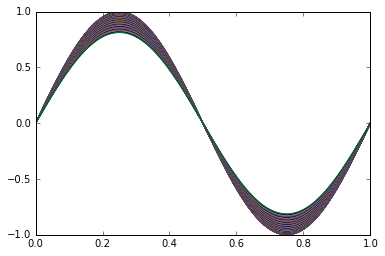

array([  0.00000000e+00,   2.03262781e-02,   4.06397178e-02,
         6.09274885e-02,   8.11767761e-02,   1.01374791e-01,
         1.21508775e-01,   1.41566011e-01,   1.61533832e-01,
         1.81399624e-01,   2.01150840e-01,   2.20775006e-01,
         2.40259724e-01,   2.59592690e-01,   2.78761692e-01,
         2.97754621e-01,   3.16559483e-01,   3.35164398e-01,
         3.53557617e-01,   3.71727521e-01,   3.89662634e-01,
         4.07351627e-01,   4.24783329e-01,   4.41946728e-01,
         4.58830985e-01,   4.75425434e-01,   4.91719594e-01,
         5.07703173e-01,   5.23366076e-01,   5.38698410e-01,
         5.53690491e-01,   5.68332848e-01,   5.82616235e-01,
         5.96531628e-01,   6.10070240e-01,   6.23223518e-01,
         6.35983154e-01,   6.48341090e-01,   6.60289520e-01,
         6.71820897e-01,   6.82927938e-01,   6.93603626e-01,
         7.03841220e-01,   7.13634252e-01,   7.22976538e-01,
         7.31862176e-01,   7.40285555e-01,   7.48241353e-01,
         7.55724546e-01,

In [116]:
c=0.01
t=10.0
nt=1000
xmin=0.0
xmax=1.0
nx=250
dt=t/nt
dx=(xmax-xmin)/nx
u=np.zeros(nx+1)
uold = u.copy()
unew = u.copy()
x = np.linspace(xmin,xmax,nx+1)
u = np.sin(2*np.pi*x)
uold = u.copy()
s = c**2 * dt**2 / dx**2
print(s)
for n in range(nt):
    for i in range(1,nx):
        unew[i] = s * (u[i+1] + u[i-1]) + 2*(1-s)*u[i] - uold[i]
    uold = u.copy()
    u = unew.copy()
    if n%10 == 0:
        plt.plot(x,unew)
plt.show()
unew

In [22]:
#  Define your main numerical loop here.

In [23]:
# your code should pass these tests---do NOT edit this cell
uold
u
unew
assert type(u)    == np.ndarray and u.shape    == (nx+1,)
assert type(uold) == np.ndarray and uold.shape == (nx+1,)
assert type(unew) == np.ndarray and unew.shape == (nx+1,)
print('Success!')

Success!


Now plot the results of the equation solution.

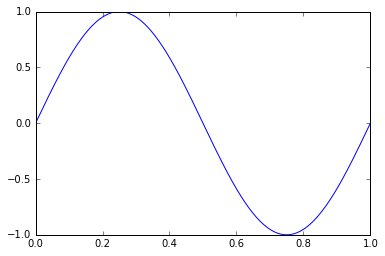

In [112]:
%matplotlib inline
plt.plot(x,unew)
plt.show()

### Plate Harmonics

The beat of a drum or the crash of cymbals relies on more than one-dimensional vibration.  Higher-order harmonics become necessary to describe shapes pulsing or vibrating in higher dimensions.  German physicist Ernst Chladni devised [a clever means of discovering these shapes empirically](https://en.wikipedia.org/wiki/Ernst_Chladni#Chladni_figures):  coat the surface with a thin layer of sand, which concentrates when the plate is struck on the vibrational nodes (or stationary parts of the wave).  Dramatic and beautiful pictures can be obtained.  ([Videos](https://youtu.be/1yaqUI4b974) are also available.)

![](https://i.ytimg.com/vi/wMIvAsZvBiw/hqdefault.jpg)

![](https://static.squarespace.com/static/549dcda5e4b0a47d0ae1db1e/54a06d6ee4b0d158ed95f696/54a06d70e4b0d158ed9602ae/1378862083897/1000w/Chladni_patterns.png)

The mathematical theory of the wave equation underlying this effect is well-understood, and we can use simple assumptions to calculate the modes of vibration for square and circular plates.  Arbitrary shapes require heavier-duty numerics to obtain.

#### Governing Equations

TODO:

- probably use scipy.special to show harmonics or something (like plate animation from MPL lesson) for circular plate at least

https://books.google.ca/books?id=VecsAAAAYAAJ&dq=chladni+die+akustik&pg=RA1-PA93&hl=en#v=onepage&q&f=true

In [ ]:
code = """FTQ MOFGMX EOUQZOQ AR XASUO UE OAZHQDEMZF MF BDQEQZF AZXK IUFT FTUZSE QUFTQD OQDFMUZ, UYBAEEUNXQ, AD QZFUDQXK PAGNFRGX---
ZAZQ AR ITUOT (RADFGZMFQXK) IQ TMHQ FA DQMEAZ AZ.  FTQDQRADQ FTQ FDGQ XASUO RAD FTUE IADXP UE FTQ OMXOGXGE AR BDANMNUXUFUQE, ITUOT
FMWQE MOOAGZF AR FTQ YMSZUFGPQ AR FTQ BDANMNUXUFK ITUOT UE, AD AGSTF FA NQ, UZ M DQMEAZMNXQ YMZ'E YUZP.  (VMYQE OXQDW YMJIQXX)"""

code_dict = calc_freq(code)
code_letters, code_freqs = dict2sort(code_dict)
plot_freq(letters, freqs, title='Expected Letter Frequency of English-Language Text')
plot_freq(code_letters, code_freqs, title='Letter Frequency in Code Text')

Of course, the correspondence isn't perfect, but we can make some reasonable guesses from this comparison.  Let's try just swapping things one-to-one across (that is, replace `'Q'` with `'e'`, `'F'` with `'t'`, etc.).  (The lower-case letters help us avoid collisions.)

In [ ]:
guess = code

for c,d in zip(code_letters, letters):
    print(c,'->',d)
    guess = guess.replace(c, d.lower())
print(guess)


<div class="alert alert-warning">
Keep in mind that you need $x+1$ points to achieve $x$ divisions in a space.
</div>

In [ ]:
guess = code

decode_pairs = [('F','T'), ('T','H'), ('Q','E'), ('D','R'), ('R','F'), ('A','O')]

for c,d in decode_pairs:
    print(c,'->',d)
    guess = guess.replace(c, d.lower())
print(guess)

Progress?  If you have the word `'trGe'`, then what is `'G'` likely to be?  What about `'eUther'` for `'U'`?  We already know how to get `'of'`, so what is `'oZ'` for `'Z'`?

In [ ]:
guess = code

decode_pairs = [('F','T'), ('T','H'), ('Q','E'), ('D','R'), ('R','F'), ('A','O'), ('G','U'), ('U','I'), ('Z','N')]

for c,d in decode_pairs:
    print(c,'->',d)
    guess = guess.replace(c, d.lower())
print(guess)

Okay, now you just have to see `'EOienOe'` as `'science'`, `'ouSht'` for `'ought'`, and `'fortunMteXK'` for `'fortunately`'.

In [ ]:
guess = code

decode_pairs = [('F','T'), ('T','H'), ('Q','E'), ('D','R'), ('R','F'), ('A','O'), ('G','U'), ('U','I'), ('Z','N'), ('E','S'), ('O','C'),
                ('S','G'), ('M','A'), ('X','L'), ('K','Y')]

for c,d in decode_pairs:
    print(c,'->',d)
    guess = guess.replace(c, d.lower())
print(guess)

The final answer can be achieved by either filling out the rest of this dictionary, or by noticing that this is a Caesar cipher from one alphabet to another offset alphabet, with no scrambling or randomization taking place.

In [ ]:
print("""The actual science of logic is conversant at present only with things either certain, impossible, or entirely doubtful---
none of which (fortunately) we have to reason on.  Therefore the true logic for this world is the calculus of Probabilities, which
takes account of the magnitude of the probability which is, or ought to be, in a reasonable man's mind.  (James Clerk Maxwell)""")

-   What is the offset you need to provide in order to *decode* the string properly user `caesar_cipher`?

In [ ]:
ans = # your answer here

Let's plot these sorted by letter frequency to clarify things:

### Rotor Cipher Machines

A straightforward extension of the basic substitution cipher (what we've referred to as the Caesar cipher) is the *polyalphabetic cipher*, in which each letter pressed on a mechanical keyboard would both be encoded and trigger a rotor to change position.  Since the rotor determines the alphabet (either the offset or a randomized substitution pattern), each letter press *changes the subsequent encoding alphabet*.  It's rather like changing the offset according to some rule every time you encoded a letter above.

To clarify this, first think of a pair of rotors, or wheels.  The inner (red) wheel represents the base alphabet (of the message), and the outer (blue) wheel represents the letter each inner letter maps to (the encoding).  An offset of one produces the following diagram:

![](./img/rotor-base.png)

A rotor cipher simply chains multiple wheels together, so that a change in one wheel produces an encoded letter *but also changes the position of the encoding rotor* for the next letter.  For instance, before encoding the letter `'A'` from the inner wheel, the rotor configuration is at left.  After encoding `'A'` (to `'B'`), the wheel advances and gives us the *new* configuration at right, in which `'A'` now maps to `'C'`.

![](./img/rotor-pair.png)

In order to think about a rotor cipher, you will have to accept a message, and for each letter in that message you will need to:

1.  Encode the letter.
2.  Advance the offset of the rotor by 1.

-   Compose a function `rotor_cipher` which accepts a string `message` and an integer `n`, the starting offset for the cipher.  `rotor_cipher` should `return` the message transformed by successively apply the rotor cipher across the alphabet.

In [ ]:
# define your function here
def rotor_cipher(message, n):
    encoded = ''
    
    # Convert the message to upper-case.
    
    # Loop over each letter of the message.
        # If the letter is in the alphabet, then:
            # 1. encode the letter
            # 2. advance the offset by 1 (modulo 26)
        # Otherwise, just add the whitespace or punctuation or numeric character to the encoded string.
    
    # Finally, return the encoded message.
    return encoded

In [ ]:
# test your code here.  You may edit this cell, and you may use any sample text, but the following is provided for convenience.
# As an example, 'HELLO' maps to 'HFNOS' if it starts with an offset of 0:  H->H, E->F (1), L->N (2), L->O (3), O->S (4).
text = 'HELLO'
rotor_cipher(text,0)

In [ ]:
# it should pass this test---do NOT edit this cell
test_text = """The observer who has thoroughly understood one link in a series of incidents should be able to accurately state all the other
ones, both before and after."""
code_text = """TIG RFXKYDNB HTB VPI KZHLJQDFKY VPGIWYAWXN ZZR ZXDB AG U NAOGDS PH LRHOKMWDD EUCJBU TX UWHB RN ADEXVFZLTH CEMGS PBC LAY JPECQ
OOGV, FTZO JNPZDR OCT RXMYM."""
result_text = rotor_cipher(test_text,0)
assert result_text == code_text
print('Success!')

In [ ]:
# it should pass this test---do NOT edit this cell
test_text = """You observed that her right glove was torn at the forefinger, but you did not apparently see that both glove and finger were
stained with violet ink. She had written in a hurry and dipped her pen too deep."""
code_text = """YPW RFXKYDNN ETNH WUI JBACP DJNVF YDW YUYV JD ETR TDHVXBHBAO, ZTT ZQX HNJ UWC KABNFTDKDR MZA QFZT CQWL LRVDN KYP SWCWVJ PYMA
PRZIOGG ANZO DRYWQG WCA. JZX BVZ TPHTUGQ MS G OCABJ MAR SYGHXX CAO NDN UQR HJKW."""
result_text = rotor_cipher(test_text,0)
assert result_text == code_text
print('Success!')

While encoding strings with a single rotor provides *some* security, it's actually easy enough to break this code with a computer since the key is only 26 characters long.  (And, in this case, in alphabetical order.)

So the next logical improvement is to randomize the order of the letters in the alphabet.  We'll skip that improvement in favor of the next:  adding a second rotor.

When this happens, the *first* rotor proceeds as we have seen before.  When it makes a complete cycle (26 characters have been encoded), then it trips the *second* rotor forward one.

That is, for offsets `1,1`, originally `'A'` maps to the first rotor at `'B'` and then to the second rotor at `'C'` for a net transformation of `'A'` to `'C'`.

![](./img/two-rotors1.png)

After encoding `'A'`, the offsets are `2,1`:  the first rotor advances (and the second stays relatively offset at one from the first rotor) such that `'A'` maps to the first rotor at `'C'` and then to the second rotor at `'D'` for a net transformation of `'A'` to `'D'`.

![](./img/two-rotors2.png)

Once things cycle back around though (26 characters), the offsets are `0,2`:  `'A'` maps to the first rotor at `'A'` and then to the second rotor at `'C'` for a net transformation of `'A'` to `'C'`.

![](./img/two-rotors3.png)

With two rotors then, the key repeats every $26 \times 26 = 676$ characters.

-   Compose a function `two_rotors` which accepts a string `message` and two integers `m` and `n`, the offsets of the first and second rotors, respectively.  `two_rotors` should `return` the `message` transformed by the two-rotor cipher method as detailed above.

In [ ]:
# define your function here
def two_rotors(message, m, n):
    encoded = ''
    # Convert the message to upper-case.
    
    # Loop over each letter of the message.
        # If the letter is in the alphabet, then:
            # 1. encode the letter
            # 2. advance the offset of the first rotor by 1 (modulo 26)
                # if the offset is now zero (one full cycle of rotor 1), then advance rotor 2
            # you may find it convenient to `print` the offsets, the letter, and the encoding to clarify things here
        # Otherwise, just add the whitespace or punctuation or numeric character to the encoded string.
    
    # Finally, return the encoded message.
    return encoded

In [ ]:
# test your code here.  You may edit this cell, and you may use any sample value, but the following is provided for convenience.
text = """Mr. Fowler being a persevering man, as a good seaman should be, blockaded the house, and having met you succeeded by certain
arguments, metallic or otherwise, in convincing you that your interests were the same as his."""
two_rotors(text,1,1)

In [ ]:
# it should pass this test---do NOT edit this cell
test_text = """Mr. Fowler being a persevering man, as a good seaman should be, blockaded the house, and having met you succeeded by certain
arguments, metallic or otherwise, in convincing you that your interests were the same as his."""
code_text = """OU. JTCSMA LPUAU P FVJLYQAOGMG ODR, FY H OXYO EROBQE KAIPHA ZD, BMRGPGKMM DSQ UCJIV, SGX CWSGMG NGX DUB ADMNQRRTT SQ VYMPXGM
ASIXRKUBB, WPFNZAYT GK IODBPVITG, LR IVVESYOVBV OFM MBVP VMTR JPWIWLACC HQES IXV KTGZ WP FHS."""
result_text = two_rotors(test_text,1,1)
assert result_text == code_text
print('Success!')

### Encoding Security

We expect this approach to be far more robust against letter frequency attacks.  Let's briefly compare the frequency of the letters in an encoded block of text:

In [ ]:
code = """'LAY “XKJNTTBDOI” SATJNBD YON RV VXMXNFZDD CTLIKRF IB DSQ ETQC FNGWAOQ VHPUH ICVYMBCTAAG QJ S WYXEJYK ASG FEQIBTJLWQ OM
UZFBNZ IBYMS. BNWLTANP CRP EHPYUUM IA PEGR PBRHV NY VACOYEVPAO KAY XKJNTTBDOI SATJNBD, UG WH QCEINP BOTAMNB IFYF BX NPRVBT QEV
BIRBQSIHCWI HUTXDDLNYS UKEUMCKKQ NF BP LRYKNZJV GMEWPRCW HL V OCZL PT FSRVBBJLWQ IOGYRTEY, XKKOUUCEPJ VYMMSNMGSH, QEV LI AKOSH.
UJH JZTKIVOYFNZ EHFTEYHO FLVPNYII GYM, QYHQISG, JYW LUHA FL DBEK GFYL, IWN T TNJT SYGLYI PEC BOOSYYGITN XFYOSGI WGK YSLIGBIU
WVJGAUNXE MF WCLFDOCIC QFD LFCWY IBUKBZGF HTSYFBKPA. F FNPF UKTXATH DZ SVJT QE SVWJQKR NF UJH VKSICSZZF CU JYW VIHLRRZBMG QYRIMAC,
QGAQIYFFL, UIZ PM EOSVK XT UVN KYAGVTH. KZBM REIJ HNDNXHJ G KNFPXBDBUEL HZ ODB RGEPTB SK LBVMEUBBH EW S KYVH SYQIBDOI JDWZNDERR XD
KWKGN KC ANMQWWEGRL VDWNRFH. QTUHLYEKE SO NA GIKOUQCSZA, O CKDTXL DO ZMLPVVDFQK PN RDD PSRYDSE WVJ YC VRJVWIS JVEW LJ M ZPSYAGY.
(VHXL SUSKQK, 1937)\n'"""

code_dict = calc_freq(code)
code_letters, code_freqs = dict2sort(code_dict)
plot_freq(letters, freqs, title='Expected Letter Frequency of English-Language Text')
plot_freq(code_letters, code_freqs, title='Letter Frequency in Code Text')

This differential equation is *separable*, meaning that it has a solution of the form

$$
u(x,t) = v(t) \cdot w(x)
$$

We know as well that the time varying portion has a solution

$$
v(t) = a \cos(\omega t) + b \sin(\omega t)
$$

with constants $a$, $b$, $\omega$ to be determined by the initial and boundary conditions.

The challenge is to solve $w(x)$.




Although you don't need to know differential equations to complete this lab, a little background will help you comprehend why the solutions work as they do.  Just as we saw for a string in one dimension, the *two-dimensional wave equation* governs the vibration (the waves) of a fixed plate.  The boundary condition specifies whether the plate edges are fixed or free; we'll fix them for simplicity in this case.

$$
\frac{\partial^2 u}{\partial t^2} + c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
\hspace{10cm}

$$

This differential equation is *separable*, meaning that it has a solution of the form

$$
u(x,y,t) = v(t) \cdot w(x,y)
$$

We know as well that the time varying portion has a solution

$$
v(t) = a \cos(\omega t) + b \sin(\omega t)
$$

with constants $a$, $\omega$, and $b$ to be determined by the initial and boundary conditions.

The challenge is to solve $w(x,y)$.




In [ ]:
def two_rotors_decode(message, m, n):
    encoded = ''
    message = message.upper()
    
    for letter in message:
        if letter in alphabet:
            encoded += mapper(letter,n+m)
            n = (n-1)%26  # the only differences to decode
            if n%26 == 0:
                m = (m-1)%26  # here as well
        else:
            encoded += letter
    
    # Finally, return the result.
    return encoded

print(two_rotors_decode(code,13,21))